# Main

In [16]:
from snowflake.snowpark.session import Session
import json
from utils import *

In [17]:
with open("config.json", "r") as file:
    connection_parameters = json.load(file)

In [18]:
sess = Session.builder.configs( connection_parameters ).create()

c:\Users\julian.quintero\FCPDIHC\PDIHC\.venv\Lib\site-packages\snowflake\connector\config_manager.py:351: UserWarning: Bad owner or permissions on C:\Users\julian.quintero\.snowflake\connections.toml
  warn(f"Bad owner or permissions on {str(filep)}{chmod_message}")


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://identity-services.elcorteingles.es:443/samlsso?SAMLRequest=pZJNc9owEIb%2Fikc9%2B9tAo8FkDEwKbdIyATrT3oS9gIosuVoZw7%2BPbIeZ9JBcetPHu7vP7rvj%2B0spnDNo5EqmJPQC4oDMVcHlISXbzYP7mThomCyYUBJScgUk95MxslJUNKvNUT7D3xrQODaRRNp9pKTWkiqGHKlkJSA1OV1nT4808gJaaWVUrgR5E%2FJxBEMEbSzhLaRAbvGOxlTU95um8ZrYU%2FrgR0EQ%2BMGdb1Wt5NNNf7E9vaMP%2FSBp9VZh5atXtimX%2FQg%2Bwtr1IqSLzWblrn6sN8TJbqgzJbEuQa9Bn3kO2%2BfHHgAtwe4ySpIw9ho7NxdqrSrwKs3PzIDg8uShVM1esBPkqqxqY2t49uTvofCFOnA7huU8JdWJF6OFnsVmngy3%2B1%2B7w%2FRPc2f0UxBVx2Y6CEdfv3yrFtkODcwzzInz8%2BZz1Pq8RKxhKVt3jX0KosQNIzcabsIBHQxpHHjDOPlNnLml5JKZLvLWAi9AGm6uLvb9oQciV9qAhRXtDWmSxH7rLaIi%2FcbQrqSe%2FN8cxv7bXK%2Br%2BN26s5yvlOD51XlQumTmffNCL%2BxeeOHuOymFknGRFYUGRGuiEKqZabAcKTG6BuJP%2Bqr%2F7vzkBQ%3D%3D&RelayState=ver%3A1-

In [19]:
alpha = 0.05

# Componente Proporcional y Gradiente (P)
T_burnin =120 # número de pasos iniciales antes de considerar ajustes proporcionales dinámicos (P) o el modelo derivativo (D).
lr = 0.02 #  tasa de aprendizaje en el componente proporcional, modulando la sensibilidad del modelo a los errores.

# Componente Integral (I)
Csat = 2.5 # Escala la saturación en el componente integral, ajustando su contribución al cuantil.
KI = 1.0 # Modula la sensibilidad del término integral a la acumulación de errores.

# Componente Derivativo (D)
ahead = 1 # Número de pasos hacia adelante  utilizada por el modelo derivativo,
seasonal_period = 7 # Periodo de la estacionalidad a modelar


n_series=5
n_points=365*3
noise_std=5
fore_std=10

In [20]:
df_snw = sess.sql( '''
    SELECT LEVEL, KEY, DT_REF,  FUTURE ,FECHA, Y, YHATFIN, YHAT_L, YHAT_U, YHAT1, YHAT2
    FROM CAA.STG_FCDP.TB_DEMAND_PLANNING_FORECAST_DEV  
    WHERE DT_REF ='2024-12-22' AND LEVEL IN ('<P>_TotD', '<P>_Prime', '<P>_LibeCsTMod','<P>_PrepCcDC      ') --'<P>_PrepCcDC',
''' )

In [21]:
df = df_snw.to_pandas()

In [22]:
df2 = assign_data_sets(df, date_col="FECHA", future_col="FUTURE", calib_ratio=0.4)

In [23]:
#df = generar_datos(n_series=n_series, n_points=n_points, seed=123, start_date="2023-01-01")
#df = assign_data_sets(df, date_col="FECHA", future_col="FUTURE", calib_ratio=0.4)

In [ ]:
df_pdi, logs = apply_pdi_with_calibration_with_diagnostics(
    df=df2,
    key_col="KEY",
    date_col="FECHA",
    value_col="Y",
    pred_col="YHATFIN",
    lower_col="YHAT_L",
    upper_col="YHAT_U",
    alpha=alpha,
    lr=lr,
    T_burnin=T_burnin,
    Csat=Csat,
    KI=KI,
    ahead=ahead,
    seasonal_period=seasonal_period,
    set_col="SET",
    smooth_method='last'
)

  2%|▏         | 55/2368 [03:38<2:58:23,  4.63s/it]

⚠️ Conjunto de entrenamiento vacío para 00101_0010702.


  2%|▏         | 59/2368 [03:49<2:18:01,  3.59s/it]

⚠️ Conjunto de entrenamiento vacío para 00101_0010707.
⚠️ Conjunto de entrenamiento vacío para 00101_0010709.


  3%|▎         | 65/2368 [04:05<2:03:40,  3.22s/it]c:\Users\julian.quintero\FCPDIHC\PDIHC\.venv\Lib\site-packages\statsmodels\tsa\statespace\exponential_smoothing.py:414: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[0])) * (high - low) + low)
  4%|▍         | 98/2368 [06:09<2:25:44,  3.85s/it]

⚠️ Conjunto de entrenamiento vacío para 00101_0010941.


  7%|▋         | 161/2368 [11:21<2:30:05,  4.08s/it]

⚠️ Conjunto de entrenamiento vacío para 00102_0010705.
⚠️ Conjunto de entrenamiento vacío para 00102_0010714.
⚠️ Conjunto de entrenamiento vacío para 00102_0010721.


  7%|▋         | 165/2368 [11:22<1:00:35,  1.65s/it]

⚠️ Conjunto de entrenamiento vacío para 00102_0010733.


 10%|▉         | 235/2368 [15:53<2:21:24,  3.98s/it]

⚠️ Conjunto de entrenamiento vacío para 00104_0010581.
⚠️ Conjunto de entrenamiento vacío para 00104_0010599.


 10%|█         | 245/2368 [16:26<2:21:08,  3.99s/it]

⚠️ Conjunto de entrenamiento vacío para 00104_0010702.


 10%|█         | 247/2368 [16:28<1:31:22,  2.58s/it]

⚠️ Conjunto de entrenamiento vacío para 00104_0010713.
⚠️ Conjunto de entrenamiento vacío para 00104_0010714.
⚠️ Conjunto de entrenamiento vacío para 00104_0010718.
⚠️ Conjunto de entrenamiento vacío para 00104_0010721.
⚠️ Conjunto de entrenamiento vacío para 00104_0010727.
⚠️ Conjunto de entrenamiento vacío para 00104_0010731.
⚠️ Conjunto de entrenamiento vacío para 00104_0010733.
⚠️ Conjunto de entrenamiento vacío para 00104_0010735.
⚠️ Conjunto de entrenamiento vacío para 00104_0010783.


 13%|█▎        | 316/2368 [20:22<2:13:00,  3.89s/it]

⚠️ Conjunto de entrenamiento vacío para 00105_0010374.


 15%|█▌        | 367/2368 [23:27<1:57:07,  3.51s/it]

⚠️ Conjunto de entrenamiento vacío para 00105_0010811.


100%|██████████| 107/107 [00:00<00:00, 107007.76it/s]


⚠️ Conjunto de entrenamiento vacío para 00106_0010714.


 19%|█▉        | 448/2368 [28:15<1:09:17,  2.17s/it]

⚠️ Conjunto de entrenamiento vacío para 00106_0010728.


 19%|█▉        | 450/2368 [28:19<1:08:19,  2.14s/it]

⚠️ Conjunto de entrenamiento vacío para 00106_0010811.


 19%|█▉        | 457/2368 [28:39<1:29:39,  2.81s/it]

⚠️ Conjunto de entrenamiento vacío para 00106_0010901.


 22%|██▏       | 518/2368 [32:44<2:06:44,  4.11s/it]

⚠️ Conjunto de entrenamiento vacío para 00107_0010599.


 22%|██▏       | 527/2368 [33:22<2:19:40,  4.55s/it]

⚠️ Conjunto de entrenamiento vacío para 00107_0010702.


100%|██████████| 8/8 [00:00<?, ?it/s]


⚠️ Conjunto de entrenamiento vacío para 00107_0010704.
⚠️ Conjunto de entrenamiento vacío para 00107_0010705.
⚠️ Conjunto de entrenamiento vacío para 00107_0010707.


100%|██████████| 116/116 [00:00<00:00, 39287.73it/s]


⚠️ Conjunto de entrenamiento vacío para 00107_0010713.


 23%|██▎       | 538/2368 [33:33<1:00:39,  1.99s/it]

⚠️ Conjunto de entrenamiento vacío para 00107_0010721.


 23%|██▎       | 540/2368 [33:34<46:47,  1.54s/it]  

⚠️ Conjunto de entrenamiento vacío para 00107_0010725.
⚠️ Conjunto de entrenamiento vacío para 00107_0010727.


 23%|██▎       | 544/2368 [33:43<1:03:51,  2.10s/it]

⚠️ Conjunto de entrenamiento vacío para 00107_0010731.
⚠️ Conjunto de entrenamiento vacío para 00107_0010732.


 23%|██▎       | 547/2368 [33:43<38:46,  1.28s/it]  

⚠️ Conjunto de entrenamiento vacío para 00107_0010734.


 23%|██▎       | 549/2368 [33:47<44:31,  1.47s/it]

⚠️ Conjunto de entrenamiento vacío para 00107_0010736.


 26%|██▋       | 627/2368 [38:54<2:15:38,  4.67s/it]

⚠️ Conjunto de entrenamiento vacío para 00108_0010704.
⚠️ Conjunto de entrenamiento vacío para 00108_0010705.
⚠️ Conjunto de entrenamiento vacío para 00108_0010713.
⚠️ Conjunto de entrenamiento vacío para 00108_0010714.
⚠️ Conjunto de entrenamiento vacío para 00108_0010718.


 27%|██▋       | 635/2368 [39:09<1:22:47,  2.87s/it]

⚠️ Conjunto de entrenamiento vacío para 00108_0010730.
⚠️ Conjunto de entrenamiento vacío para 00108_0010735.


 27%|██▋       | 638/2368 [39:14<1:09:20,  2.41s/it]

⚠️ Conjunto de entrenamiento vacío para 00108_0010811.


 30%|███       | 714/2368 [43:57<1:45:51,  3.84s/it]

⚠️ Conjunto de entrenamiento vacío para 00109_0010702.


 30%|███       | 716/2368 [44:02<1:29:23,  3.25s/it]

⚠️ Conjunto de entrenamiento vacío para 00109_0010713.
⚠️ Conjunto de entrenamiento vacío para 00109_0010714.


 30%|███       | 719/2368 [44:10<1:19:31,  2.89s/it]

⚠️ Conjunto de entrenamiento vacío para 00109_0010721.


 30%|███       | 721/2368 [44:13<1:06:59,  2.44s/it]

⚠️ Conjunto de entrenamiento vacío para 00109_0010723.
⚠️ Conjunto de entrenamiento vacío para 00109_0010725.
⚠️ Conjunto de entrenamiento vacío para 00109_0010732.
⚠️ Conjunto de entrenamiento vacío para 00109_0010735.
⚠️ Conjunto de entrenamiento vacío para 00109_0010736.


 31%|███       | 733/2368 [44:41<1:36:01,  3.52s/it]

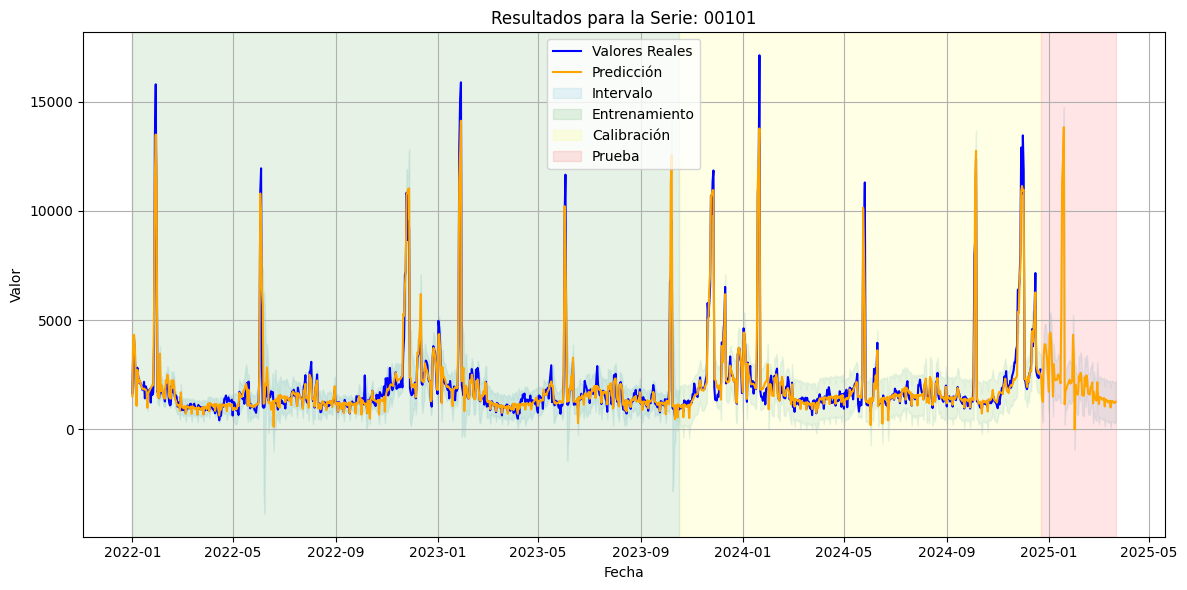

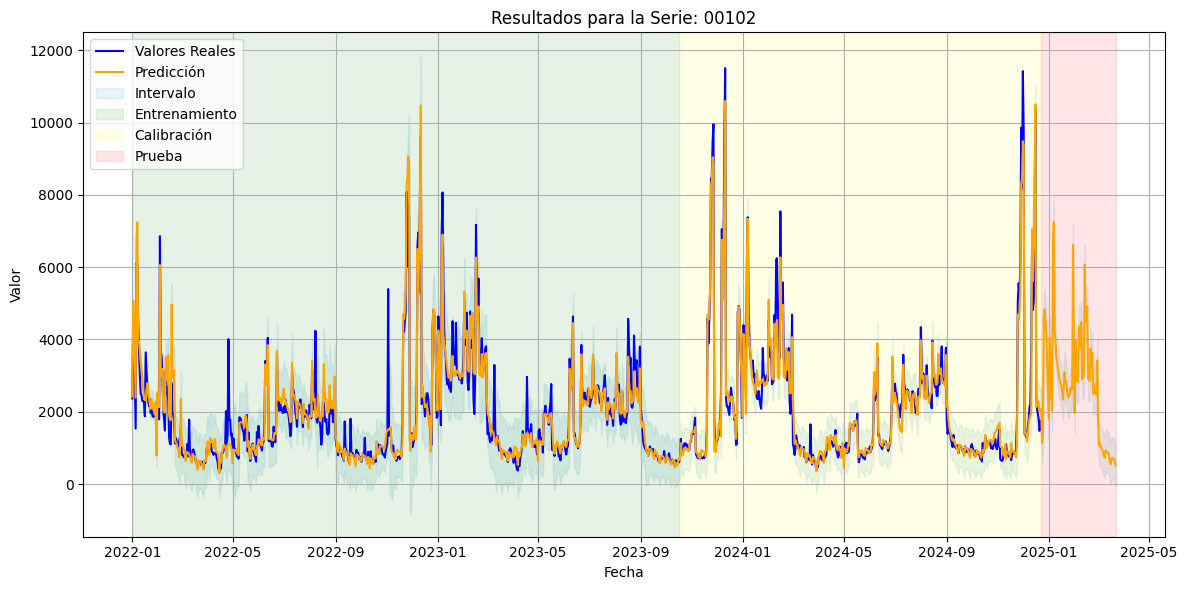

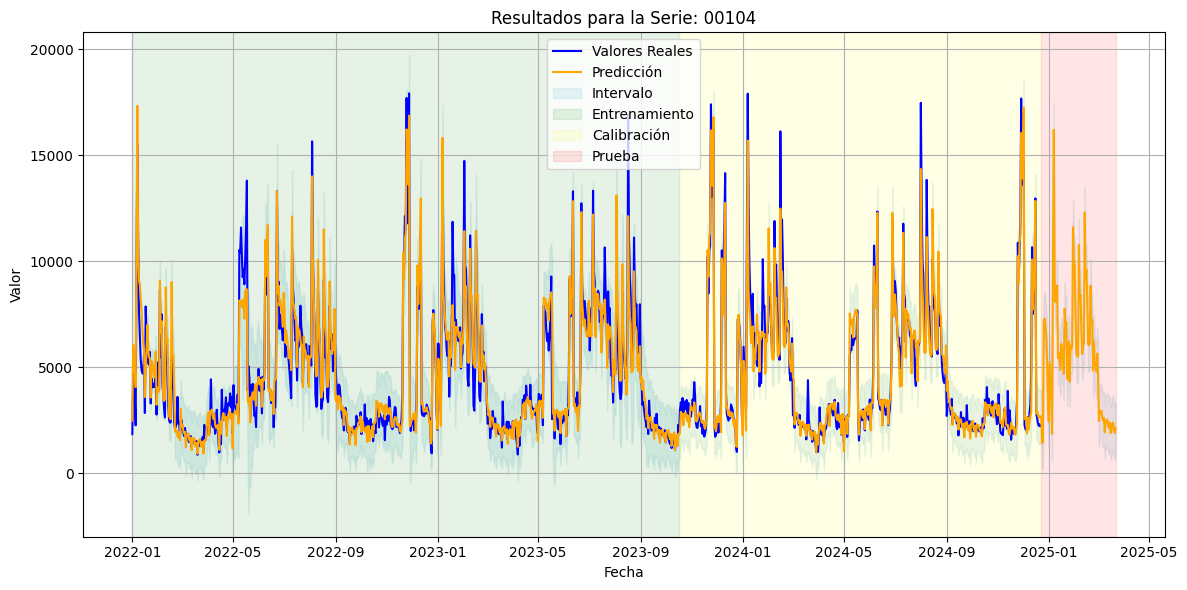

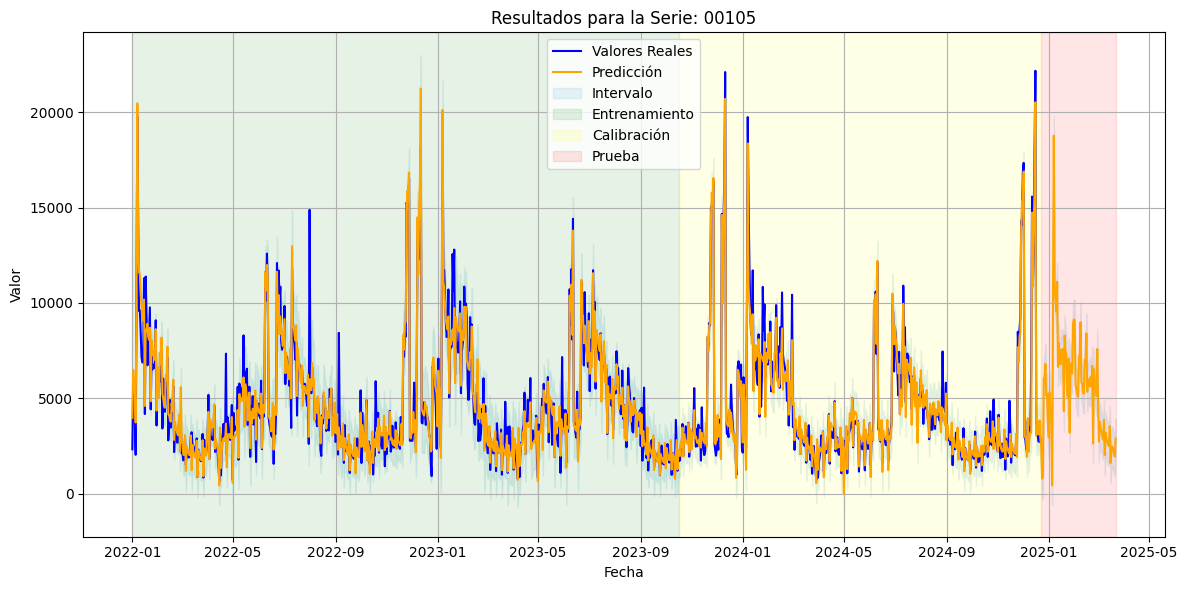

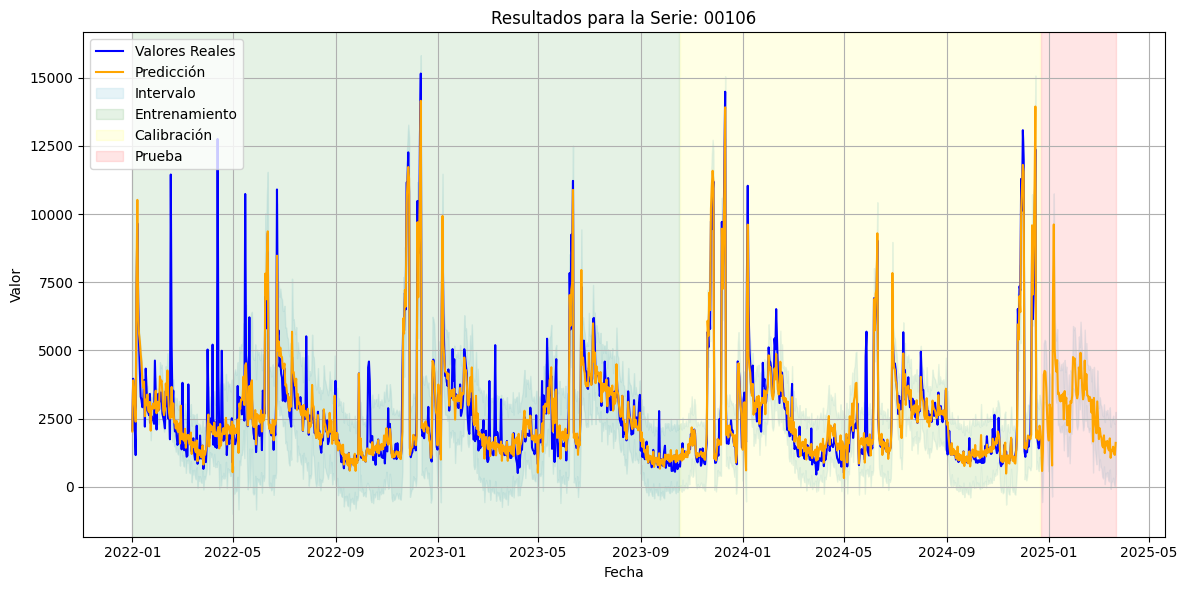

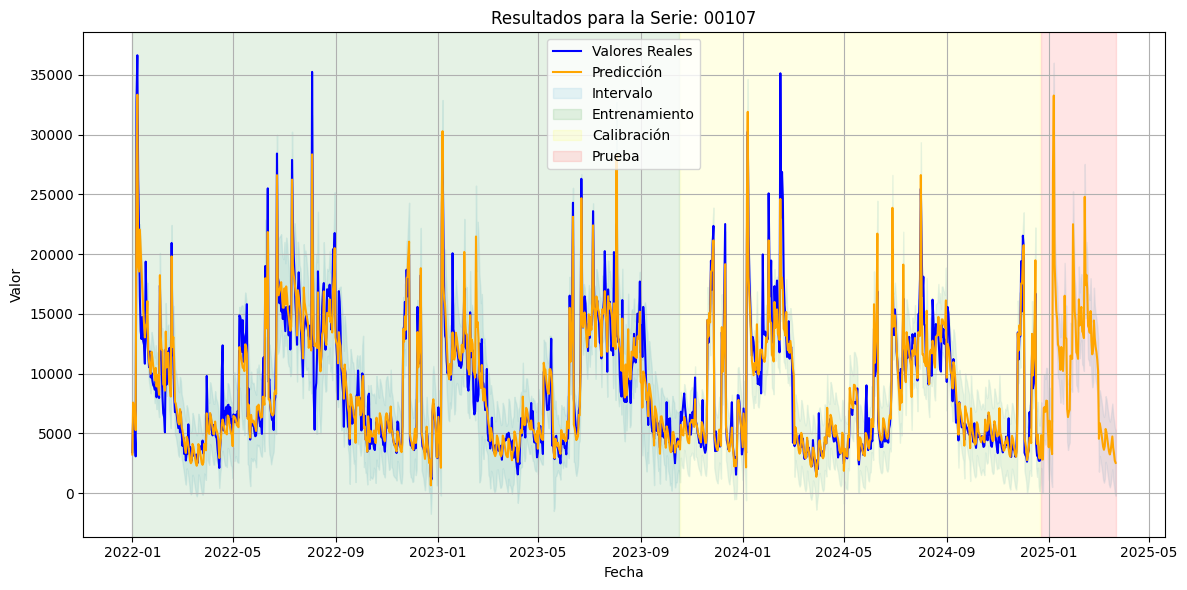

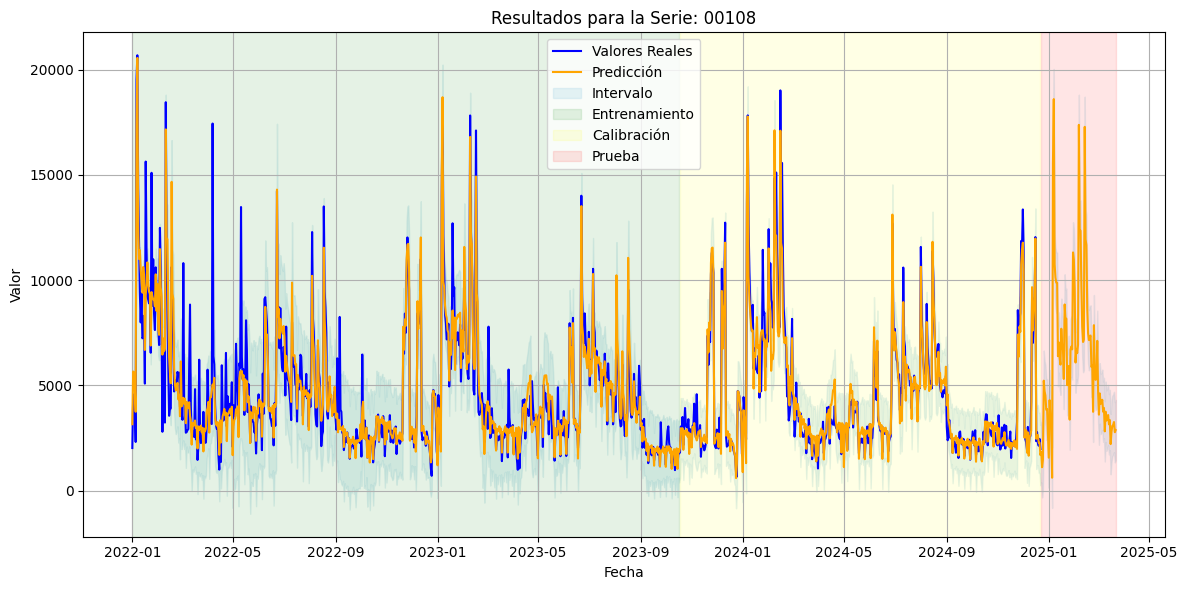

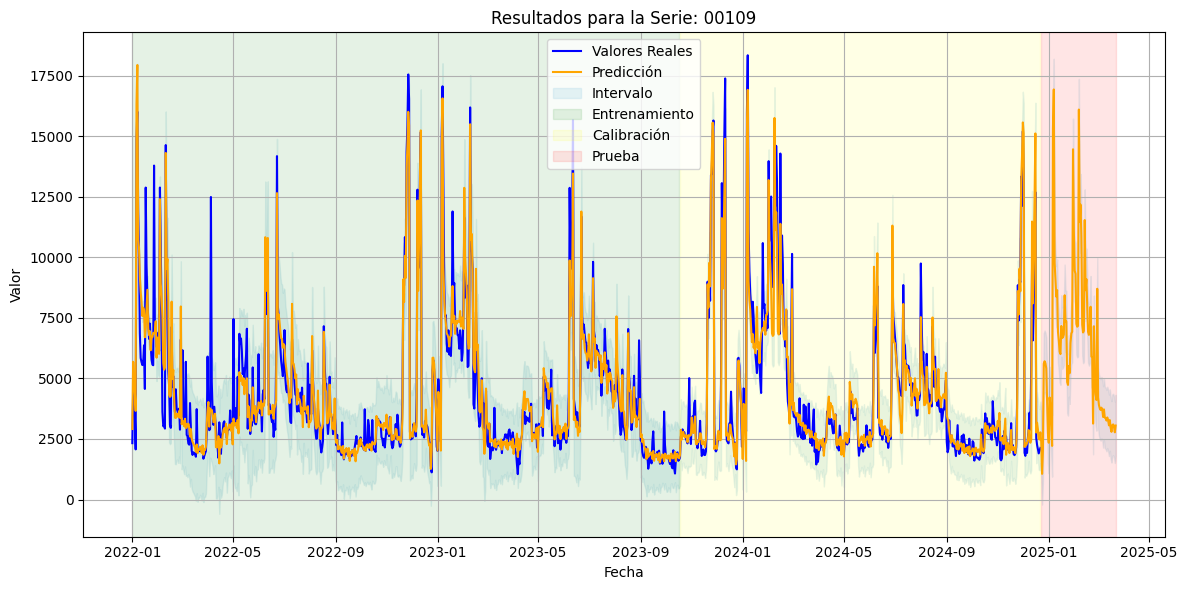

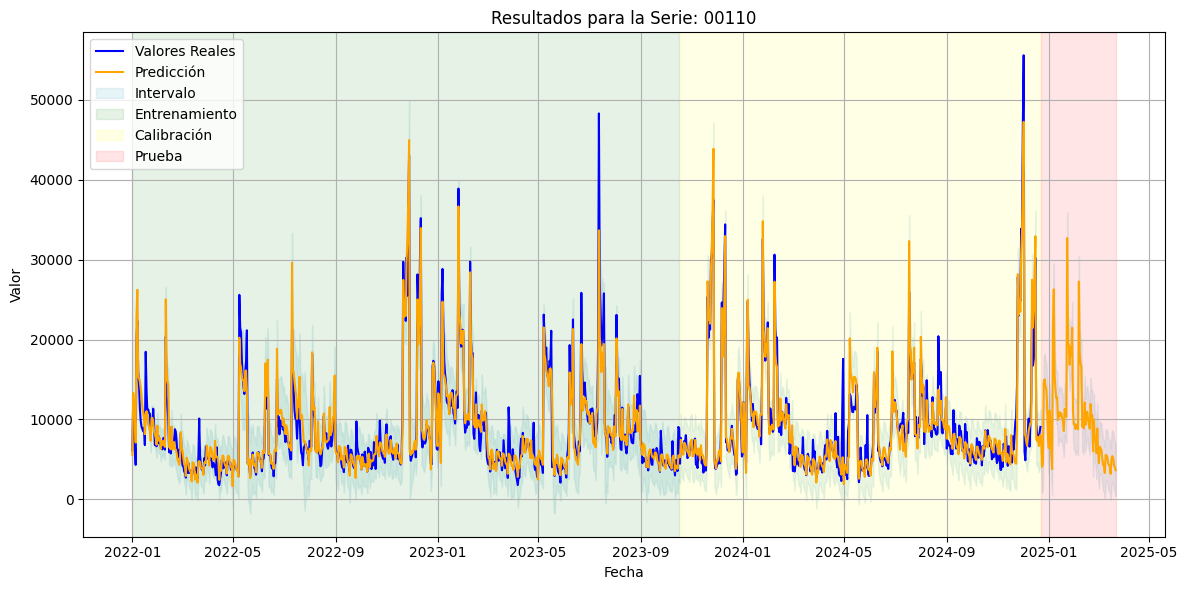

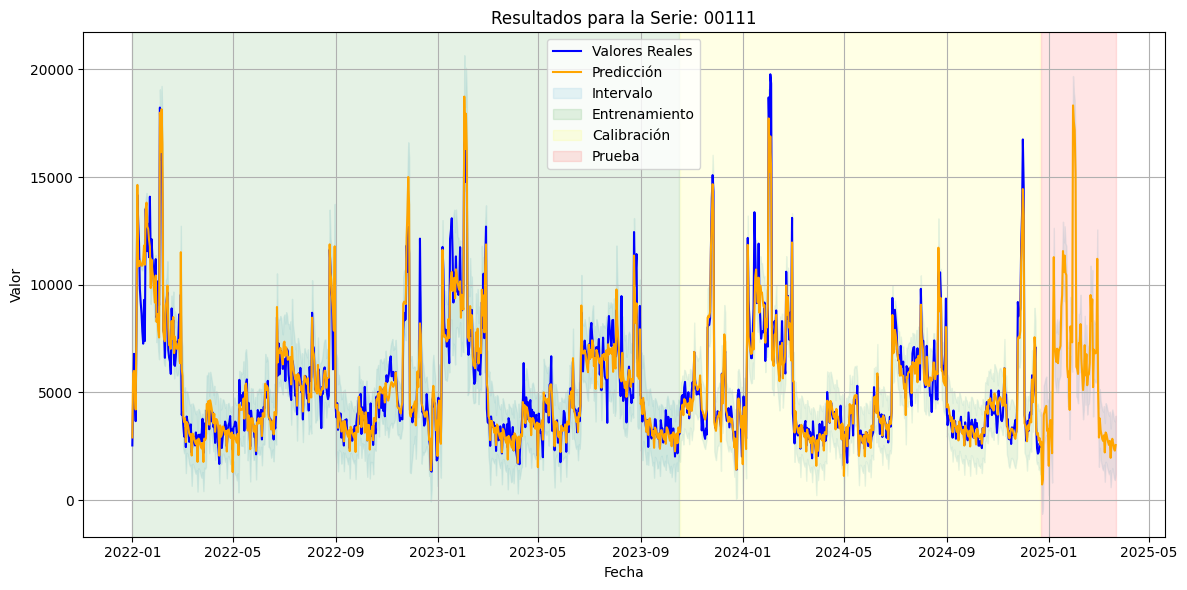

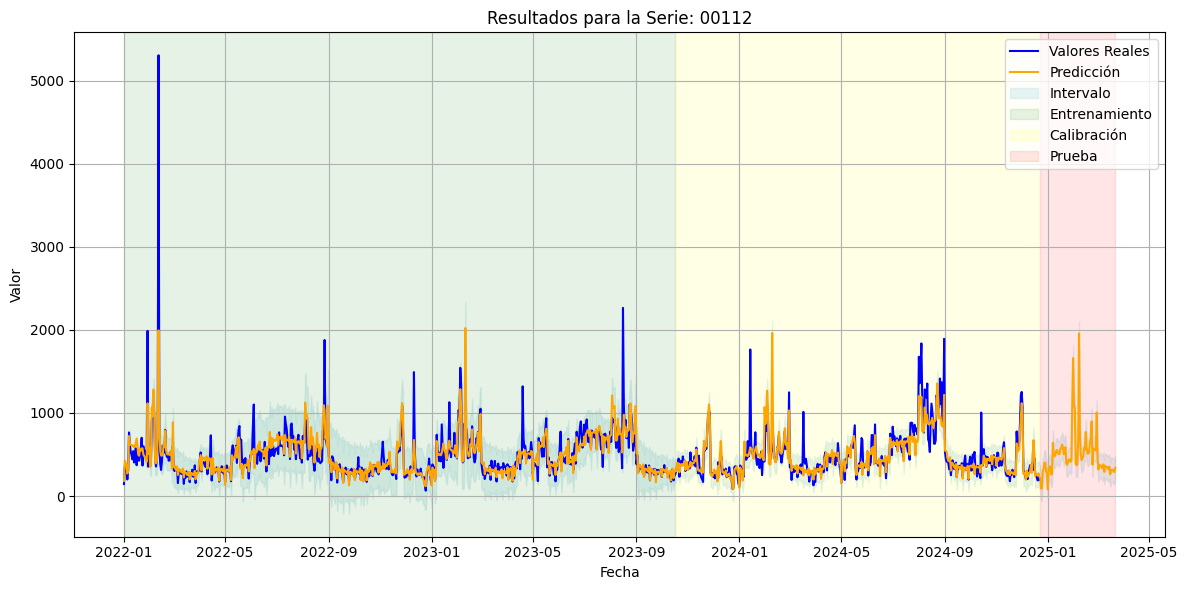

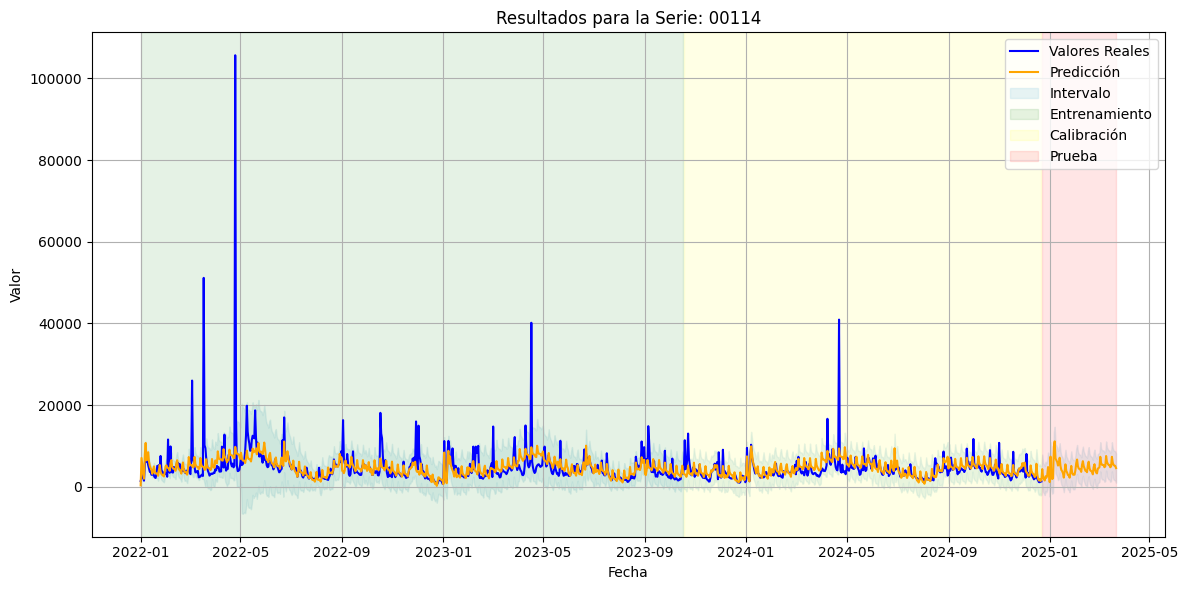

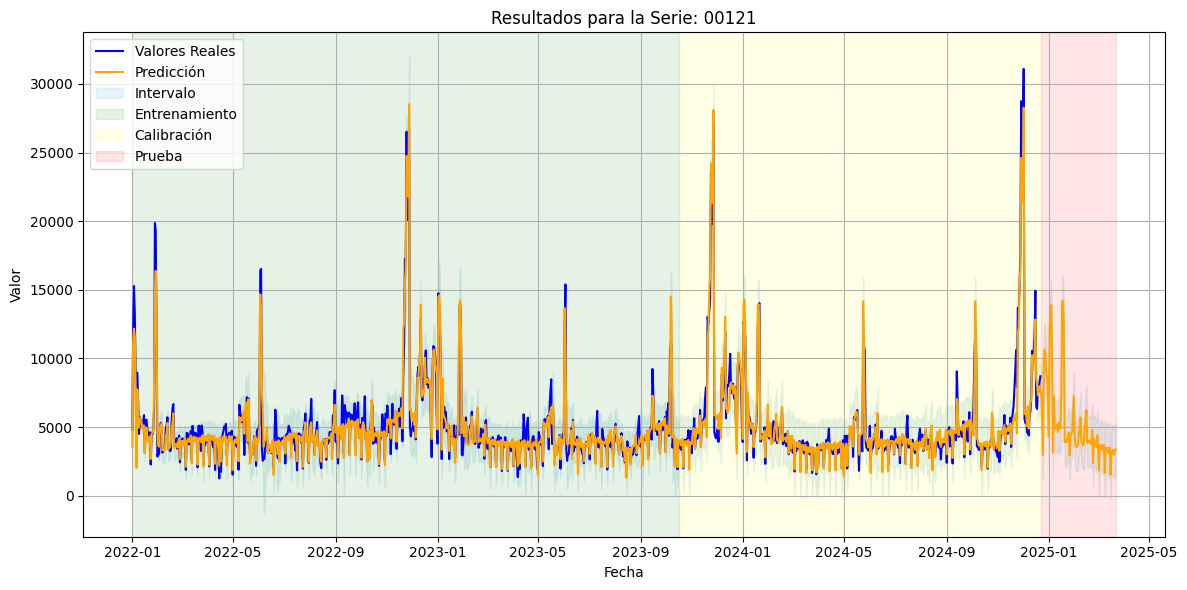

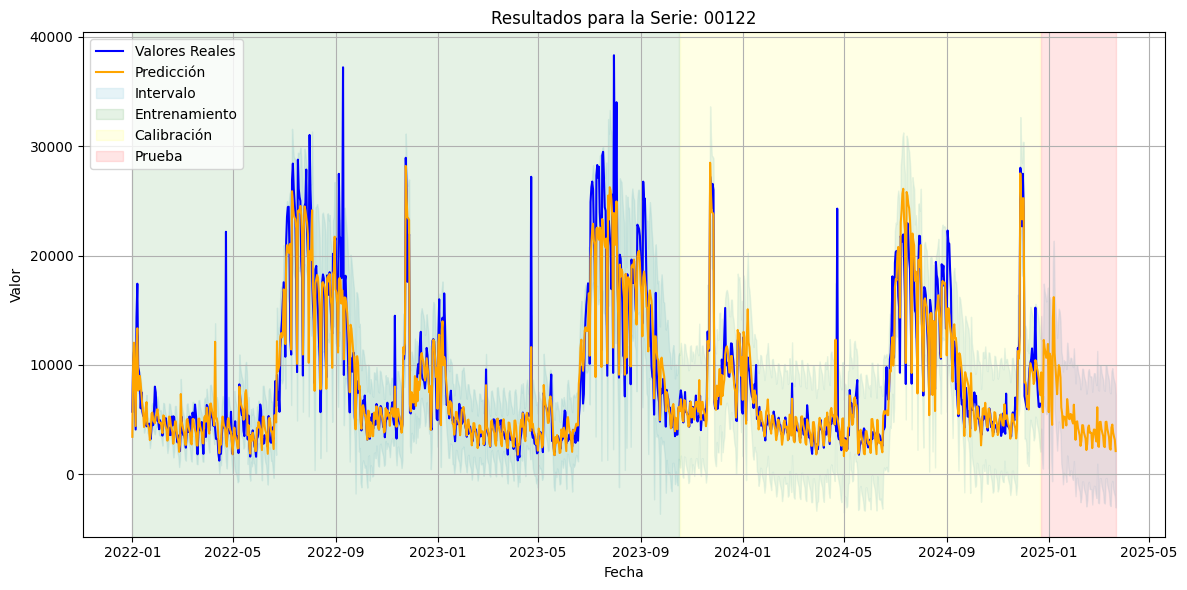

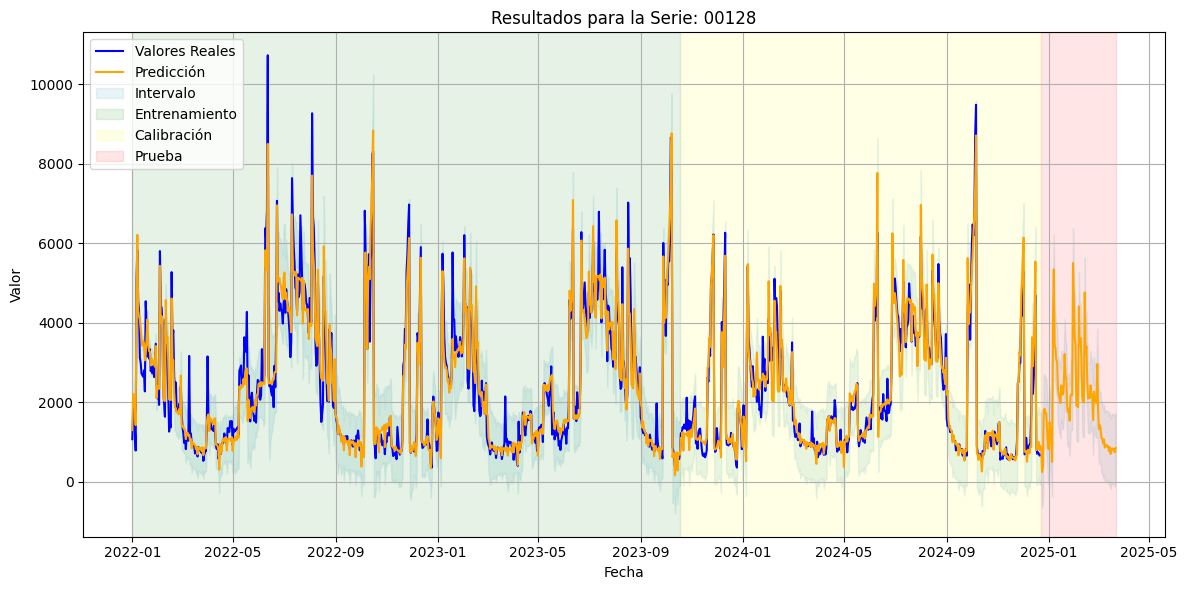

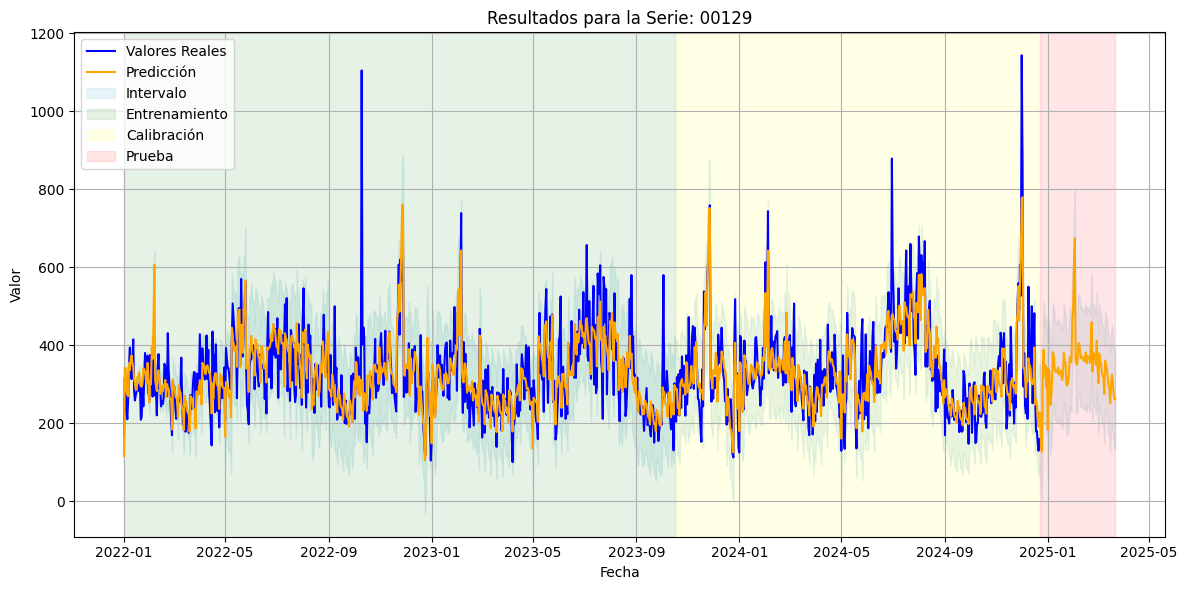

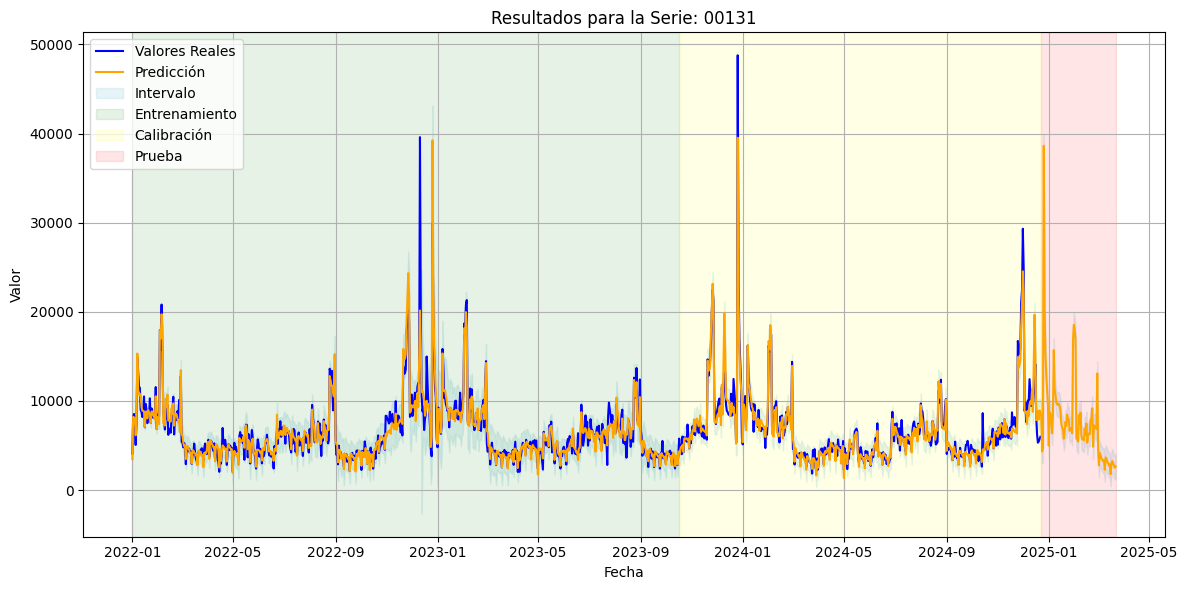

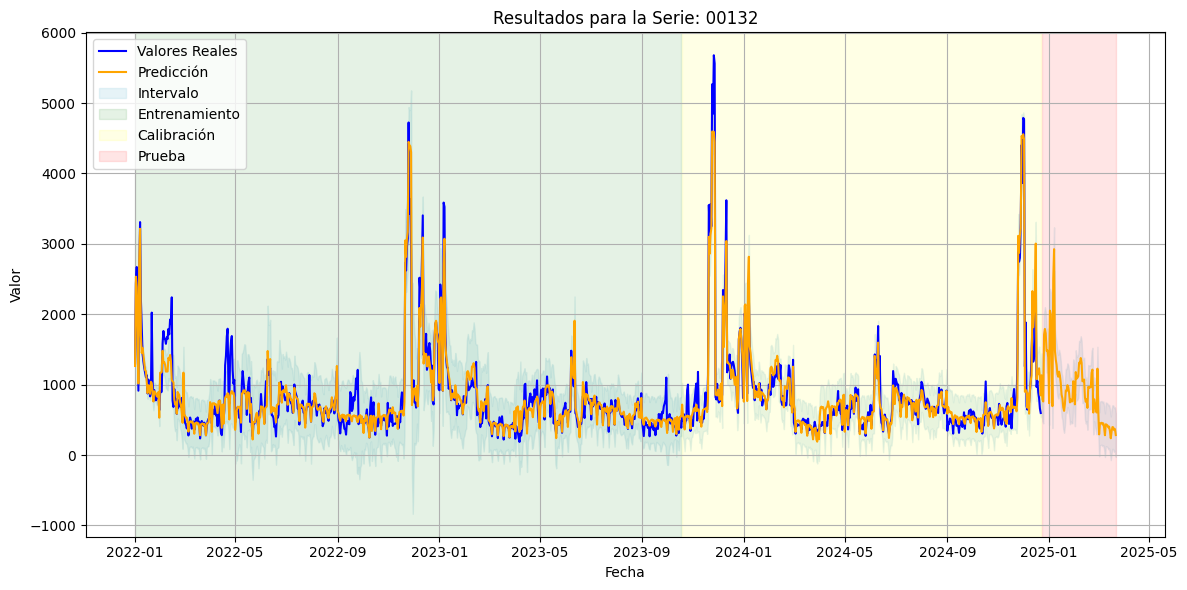

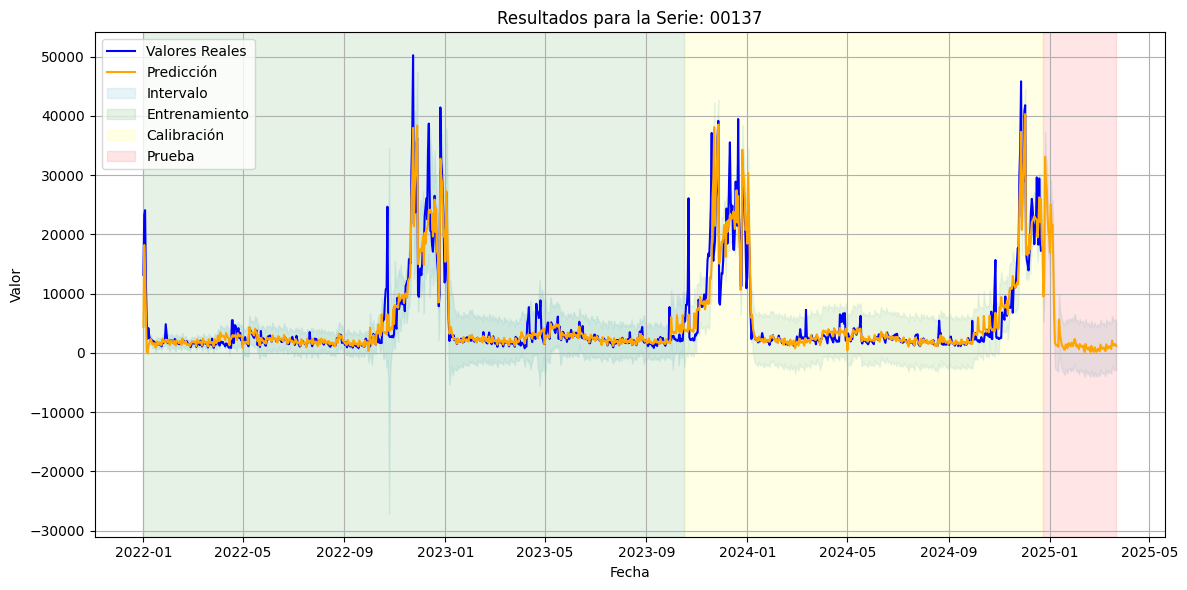

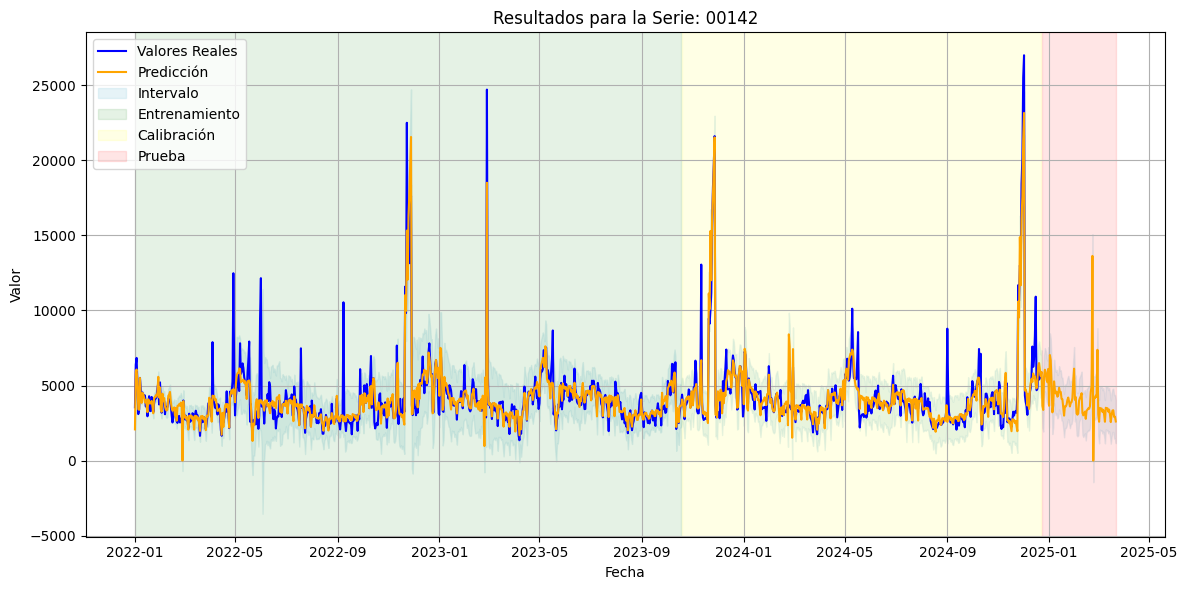

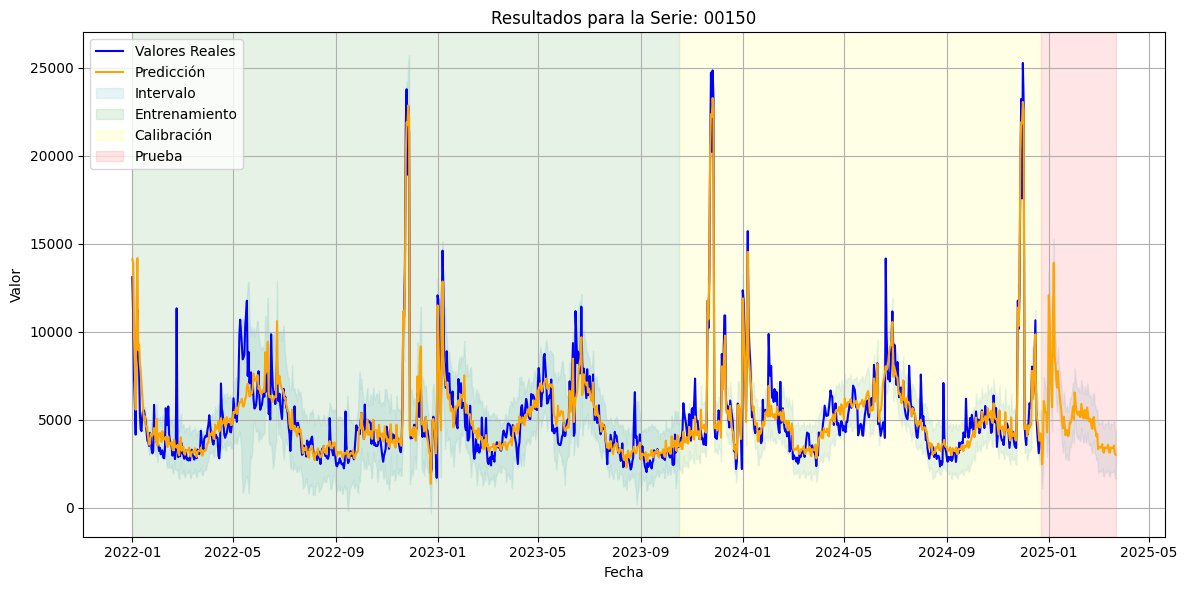

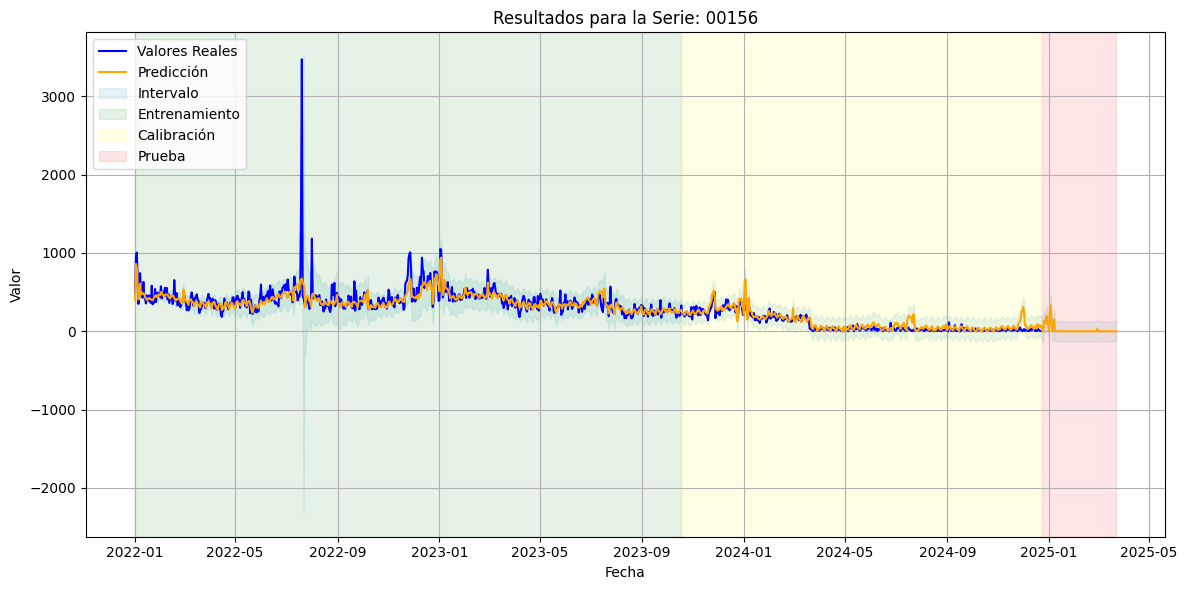

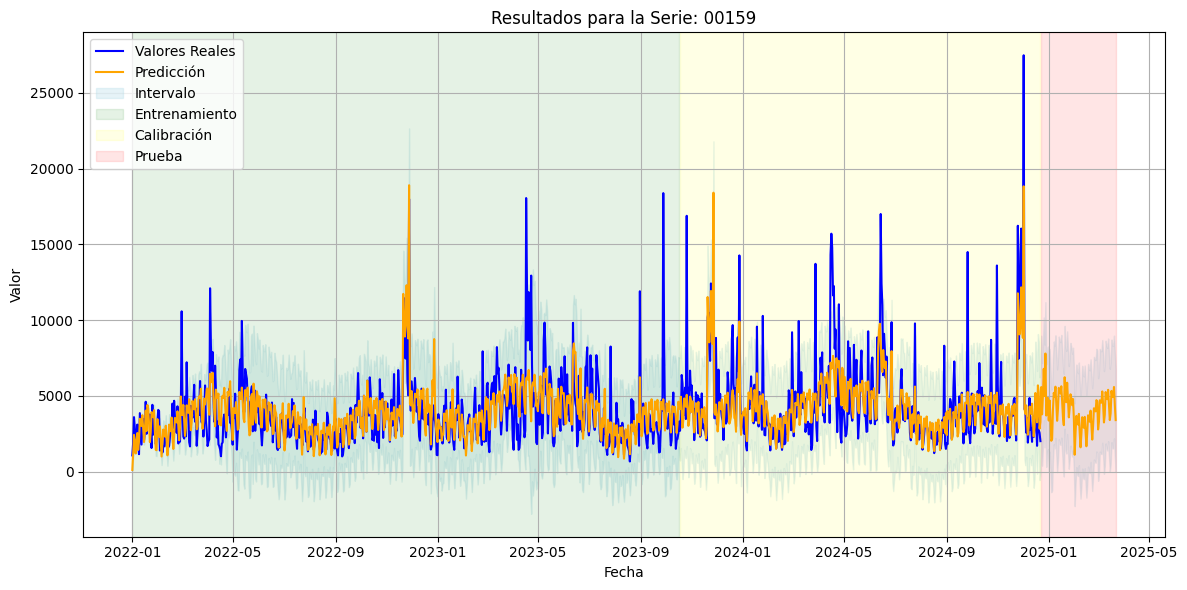

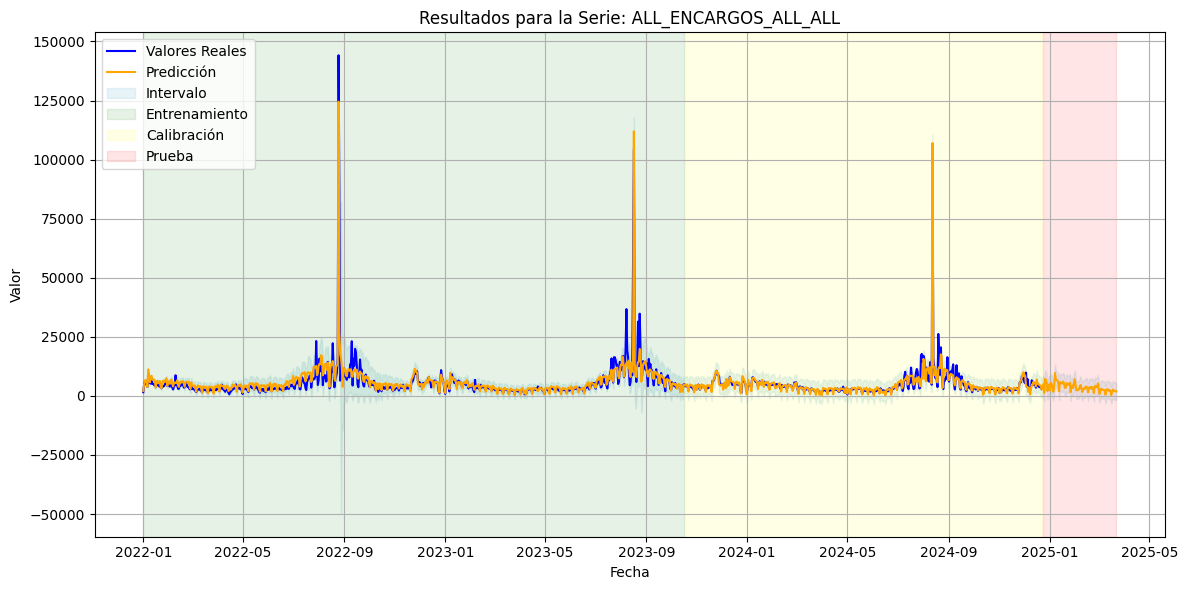

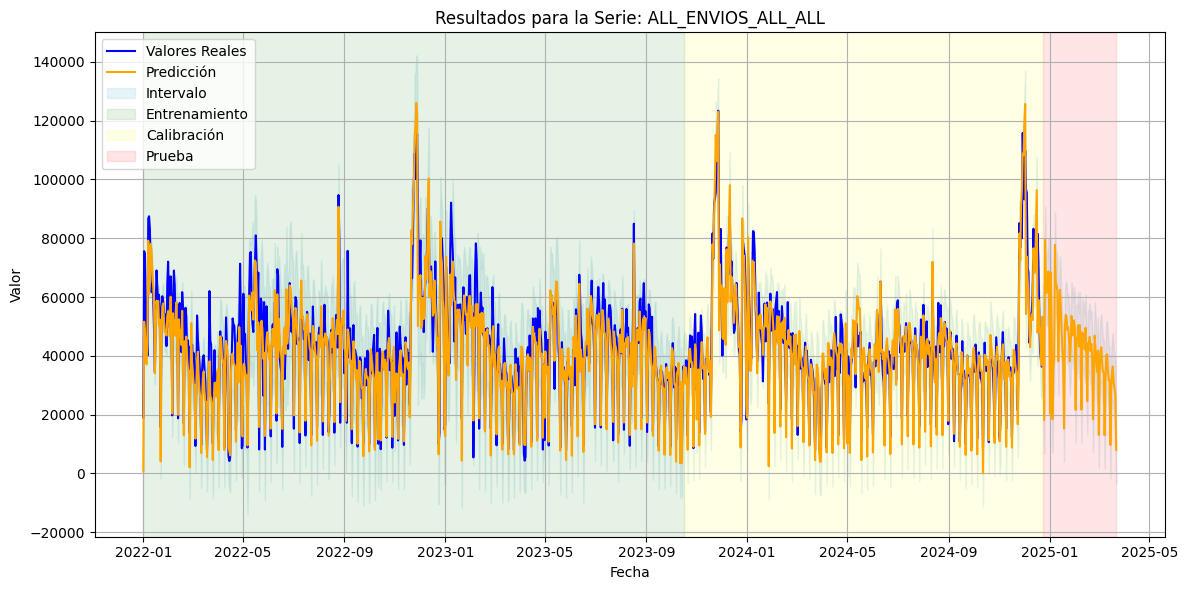

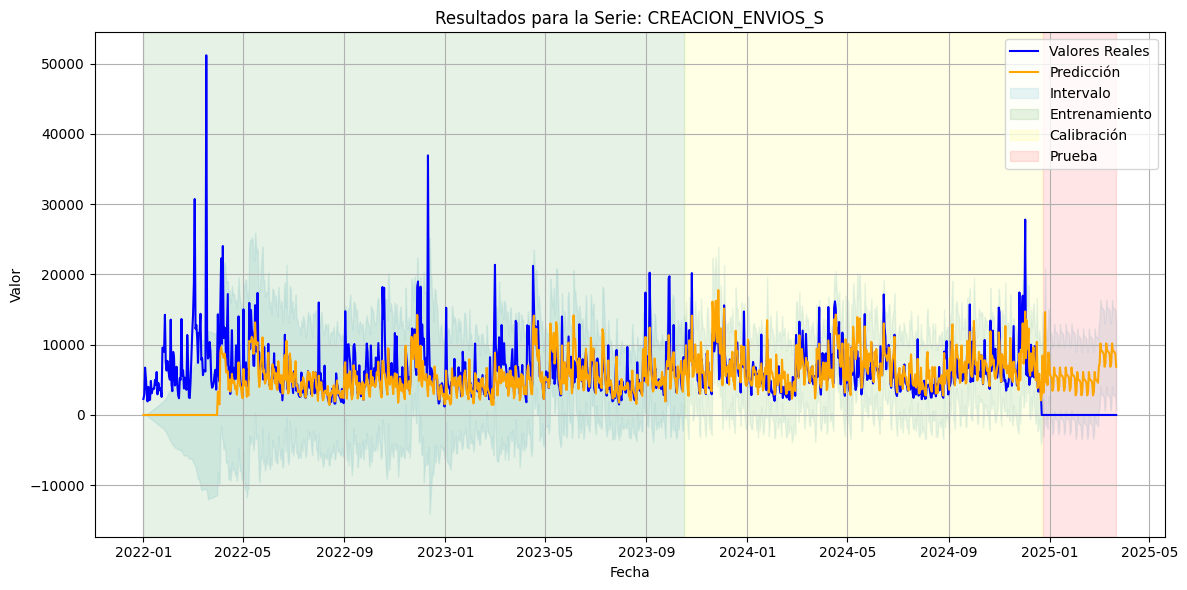

In [11]:
unique_keys = df_pdi['KEY'].unique()

for key in unique_keys:
    plot_series_results_with_sets(df_pdi, key=key)

In [12]:
# Dividir el DataFrame en TRAIN, CALIBRATION y TEST
train_df = df_pdi[df_pdi["SET"] == "TRAIN"]
calib_df = df_pdi[df_pdi["SET"] == "CALIBRATION"]
test_df = df_pdi[df_pdi["SET"] == "TEST"]

# Calcular métricas por serie (KEY) para el conjunto de calibración
calib_metrics_by_key = calculate_metrics(
    calib_df,
    value_col="Y",
    lower_col="YHAT_L",
    upper_col="YHAT_U",
    alpha=alpha,
    condition_col="KEY"
)

# Mostrar resultados
print("Métricas por KEY (Calibración):")
print(calib_metrics_by_key.to_string())


Métricas por KEY (Calibración):
                   Group  Marginal Coverage  Coverage Deviation  Average Region Size  Winkler Score
0                  00101           0.962963            0.012963          1851.956028    3340.592562
1                  00102           0.909722           -0.040278          1150.975381    2796.468228
2                  00104           0.886574           -0.063426          2517.119780    5626.649296
3                  00105           0.902778           -0.047222          2103.446804    5262.193495
4                  00106           0.956019            0.006019          2275.125070    3393.076312
5                  00107           0.914352           -0.035648          5495.055703   11278.543980
6                  00108           0.939815           -0.010185          2868.850179    4849.105725
7                  00109           0.886574           -0.063426          2533.742246    6029.646633
8                  00110           0.914352           -0.035648     

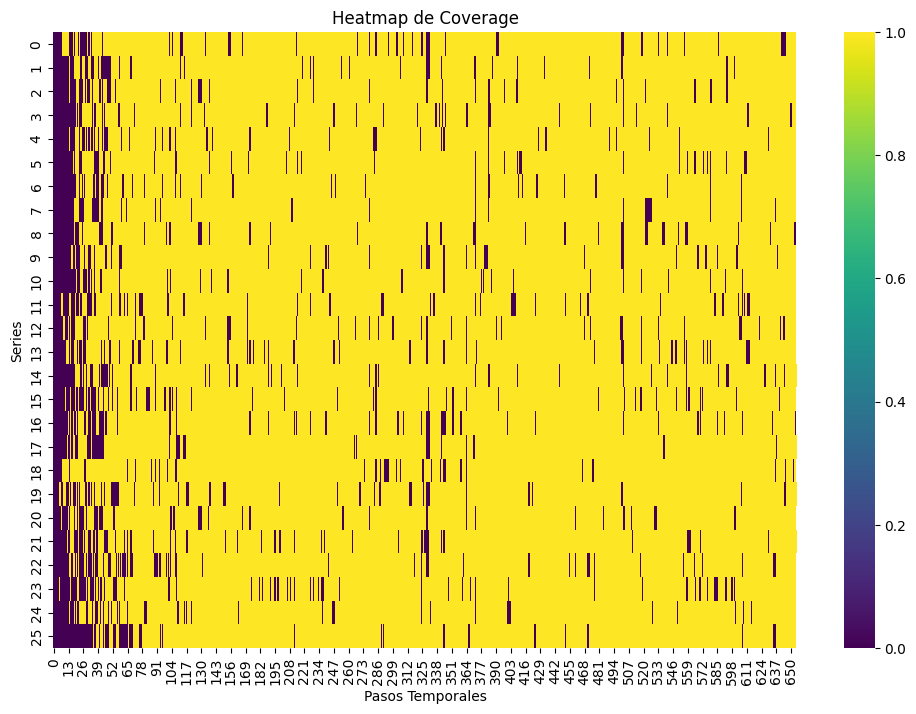

In [ ]:
plot_heatmap(logs, component="coverage")

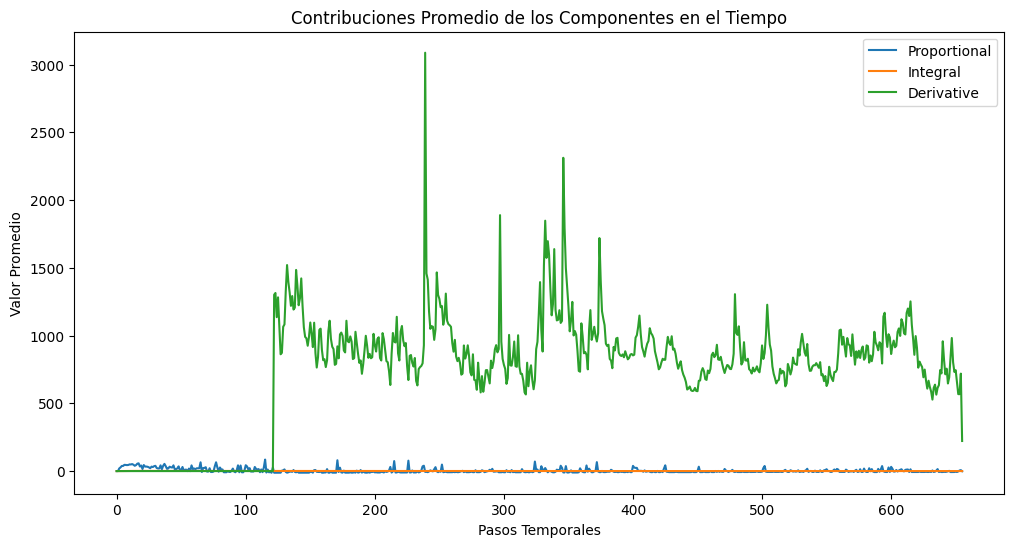

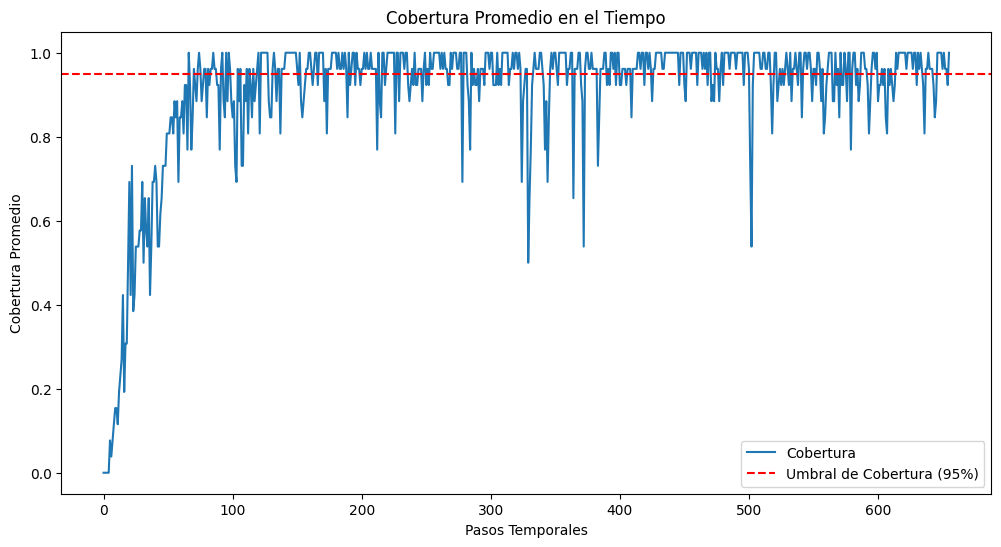

In [ ]:
plot_logs_agg(aggregate_logs_average(logs))

In [15]:
calib_metrics = calculate_metrics(
    calib_df,
    value_col="Y",
    lower_col="YHAT_L",
    upper_col="YHAT_U",
    alpha=alpha
)
calib_metrics

Group  Marginal Coverage  Coverage Deviation  Average Region Size  \
0  Global           0.928571           -0.021429          4619.560306   

   Winkler Score  
0    8549.674572